# Simulate Kuramoto on a hypergraph ring

In [22]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="notebook")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

## Generate structure

In [3]:
N = 83
H = xgi.trivial_hypergraph(N)

r1 = 2
r2 = 2

print(H)

Unnamed Hypergraph with 83 nodes and 0 hyperedges


## Dynamics

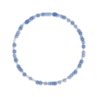

In [10]:
# Set parameters

# dynamical
k1 = 1  # pairwise coupling strength
k2 = 1  # triplet coupling strength
omega = 0  # 1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)

ic = "random"  # initial condition type, see below
noise = 0  # noise strength

psi_init = generate_state(N=83, kind=ic,noise=noise)

# integration
t_end = 400
dt = 0.01
times = np.arange(0, t_end + dt / 2, dt)
integrator = "RK45"

tag_params = f"k1_{k1}_k2_{k2}_ic_{ic}"

fig, ax = plt.subplots(figsize=(1, 1))
plot_phases(psi_init, it=None, ax=ax)
plt.show()


In [11]:
n_reps = 10

# simulate

thetas_arr = np.zeros((n_reps, N, len(times)))

for i in tqdm(range(n_reps)):
    psi_init = generate_state(N, kind="random", noise=noise)

    thetas, times = simulate_kuramoto(
        H,
        k1=k1,
        k2=k2,
        omega=omega,
        theta_0=psi_init,
        t_end=t_end,
        dt=dt,
        rhs=rhs_ring_nb,
        integrator=integrator,
        args=(r1, r2),
        t_eval=False,
    )

    thetas_arr[i] = thetas

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.97it/s]


(-2, True)
-2-twisted


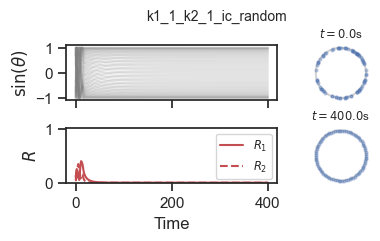

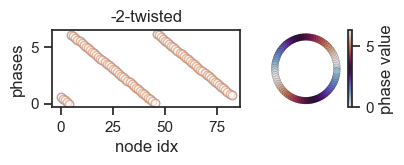

In [13]:
# plot the last repetition
i = 4
fig, axs = plot_sync(thetas_arr[i], times)

axs[0, 1].set_title(f"$t={times[0]}$s", fontsize="x-small")
axs[1, 1].set_title(f"$t={times[-1]}$s", fontsize="x-small")

axs[0, 0].set_xlabel("")
axs[1, 0].legend(loc="best", fontsize="x-small")

plt.subplots_adjust(hspace=0.5, top=0.8)

fig.suptitle(tag_params, fontsize="small")

# only to viz twisted states
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 1), width_ratios=[2, 1])

ax1.plot(thetas_arr[i, :, -1] % (2 * np.pi), "o", mfc="w", alpha=0.5)
ax1.plot(thetas_arr[i, :, -10000] % (2 * np.pi), "o", mfc="w", alpha=0.5)
ax1.set_ylabel("phases")
ax1.set_xlabel("node idx")

ax1.set_title(identify_state(thetas_arr[i], atol=0.01))

pos = xgi.circular_layout(H)
ax2, ims = xgi.draw_nodes(
    H,
    pos=pos,
    node_fc=thetas_arr[i, :, -1] % (2 * np.pi),
    node_fc_cmap="twilight",
    node_size=5,
    node_lw=0.1,
    vmin=0,
    vmax=6.28,
)
plt.colorbar(ims, label="phase value")

print(identify_winding_number(thetas_arr[i], t=-1))
# print(winding_number(thetas_arr[i].T, N, -1, atol=0.5))
print(identify_state(thetas_arr[i], atol=0.001))

In [14]:
states = [identify_state(thetas, atol=0.01) for thetas in thetas_arr]
set(states)

{'-1-twisted',
 '-2-twisted',
 '0-twisted',
 '1-twisted',
 '2-twisted',
 '3-twisted'}

In [15]:
states_unique, counts = np.unique(states, return_counts=True)
states_unique, counts

(array(['-1-twisted', '-2-twisted', '0-twisted', '1-twisted', '2-twisted',
        '3-twisted'], dtype='<U10'),
 array([1, 2, 2, 2, 2, 1]))

In [16]:
states

['0-twisted',
 '1-twisted',
 '-2-twisted',
 '1-twisted',
 '-2-twisted',
 '-1-twisted',
 '3-twisted',
 '2-twisted',
 '0-twisted',
 '2-twisted']

## Loop over k2

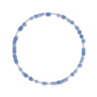

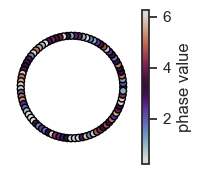

In [17]:
###### Set parameters

# dynamical
k1 = 1  # pairwise coupling strength
k2 = 0  # triplet coupling strength
omega = 1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)

ic = "random"  # initial condition type, see below
noise = 0  # noise strength

psi_init = generate_state(N, kind=ic, noise=noise)

# integration
t_end = 200
dt = 0.01
times = np.arange(0, t_end + dt / 2, dt)

tag_params = f"k1_{k1}_k2_{k2}_ic_{ic}"

fig, ax = plt.subplots(figsize=(1, 1))
plot_phases(psi_init, it=None, ax=ax)
plt.show()

# only to viz twisted states
fig, ax = plt.subplots(figsize=(2, 2))
ax, ims = xgi.draw(
    H, pos=pos, node_fc=psi_init % (2 * np.pi), node_fc_cmap="twilight", node_size=5
)
plt.colorbar(ims[0], label="phase value")

In [18]:
n_reps = 10

k2s = [0, 0.5, 1, 1.5, 2, 2.5, 3]

# simulate

thetas_arr = np.zeros((n_reps, len(k2s), N, len(times)))

for j, k2 in enumerate(k2s):
    for i in tqdm(range(n_reps)):
        psi_init = generate_state(N, kind="random", noise=noise)

        thetas, times = simulate_kuramoto(
            H,
            k1=k1,
            k2=k2,
            omega=omega,
            theta_0=psi_init,
            t_end=t_end,
            dt=dt,
            rhs=rhs_ring_nb,
            integrator=integrator,
            args=(r1, r2),
            t_eval=False,
        )

        thetas_arr[i, j] = thetas

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.34it/s]


In [19]:
results = {}

for j, k2 in enumerate(tqdm(k2s)):
    states = [identify_state(thetas, atol=0.5) for thetas in thetas_arr[:, j]]
    states_unique, counts = np.unique(states, return_counts=True)
    probs = counts / n_reps

    results[k2] = {}
    for state, prob in zip(states_unique, probs):
        results[k2][state] = prob

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.05it/s]


In [20]:
results

{0: {'-1-twisted': 0.1,
  '-2-twisted': 0.2,
  '0-twisted': 0.2,
  '1-twisted': 0.3,
  'other': 0.1,
  'sync': 0.1},
 0.5: {'-1-twisted': 0.3,
  '0-twisted': 0.3,
  '1-twisted': 0.1,
  '2-twisted': 0.3},
 1: {'-1-twisted': 0.5, '0-twisted': 0.4, '3-twisted': 0.1},
 1.5: {'-1-twisted': 0.3,
  '-2-twisted': 0.1,
  '-3-twisted': 0.1,
  '0-twisted': 0.2,
  '1-twisted': 0.1,
  '2-twisted': 0.1,
  '3-twisted': 0.1},
 2: {'-1-twisted': 0.2,
  '-4-twisted': 0.1,
  '0-twisted': 0.1,
  '1-twisted': 0.2,
  'other': 0.4},
 2.5: {'-1-twisted': 0.2,
  '-2-twisted': 0.2,
  '-4-twisted': 0.1,
  '3-twisted': 0.1,
  'other': 0.4},
 3: {'-2-twisted': 0.1, '-4-twisted': 0.1, 'other': 0.8}}

In [24]:
df = pd.DataFrame.from_dict(results, orient="index").reset_index(names="k2")
df

,k2,-1-twisted,-2-twisted,0-twisted,1-twisted,other,sync,2-twisted,3-twisted,-3-twisted,-4-twisted
0,0.0,0.1,0.2,0.2,0.3,0.1,0.1,NaN,NaN,NaN,NaN
1,0.5,0.3,NaN,0.3,0.1,NaN,NaN,0.3,NaN,NaN,NaN
2,1.0,0.5,NaN,0.4,NaN,NaN,NaN,NaN,0.1,NaN,NaN
3,1.5,0.3,0.1,0.2,0.1,NaN,NaN,0.1,0.1,0.1,NaN
4,2.0,0.2,NaN,0.1,0.2,0.4,NaN,NaN,NaN,NaN,0.1
5,2.5,0.2,0.2,NaN,NaN,0.4,NaN,NaN,0.1,NaN,0.1
6,3.0,NaN,0.1,NaN,NaN,0.8,NaN,NaN,NaN,NaN,0.1


In [25]:
df_long = df.melt(id_vars="k2", var_name="state", value_name="proba")
df_long

,k2,state,proba
0,0.0,-1-twisted,0.1
1,0.5,-1-twisted,0.3
2,1.0,-1-twisted,0.5
3,1.5,-1-twisted,0.3
4,2.0,-1-twisted,0.2
...,...,...,...
65,1.0,-4-twisted,NaN
66,1.5,-4-twisted,NaN
67,2.0,-4-twisted,0.1
68,2.5,-4-twisted,0.1


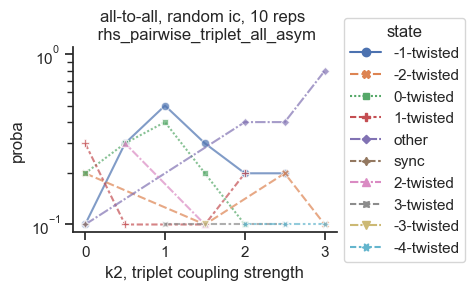

In [26]:
fig, ax = plt.subplots(figsize=(3.4, 2.4))
g = sb.lineplot(
    data=df_long,
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    alpha=0.7,
    style="state",
    # hue_order=["sync", "2-cluster", "other"]
    legend=True,
)

g.set(yscale="log")

ax.set_xlabel("k2, triplet coupling strength")

title = f"all-to-all, {ic} ic, {n_reps} reps \n rhs_pairwise_triplet_all_asym"
ax.set_title(title)

sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5))


sb.despine()
ax.set_ylim(ymax=1.1)

fig_name = f"basin_size_a2a_ic_{ic}_nreps_{n_reps}_rhs_pairwise_triplet_all_asym"

# plt.savefig(f"{results_dir}{fig_name}.png", dpi=300, bbox_inches="tight")

'0-twisted'

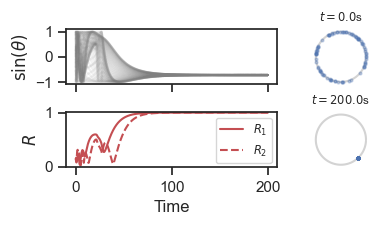

In [27]:
# plot the last repetition
i = 5
j = 3
fig, axs = plot_sync(thetas_arr[i, j], times)

axs[0, 1].set_title(f"$t={times[0]}$s", fontsize="x-small")
axs[1, 1].set_title(f"$t={times[-1]}$s", fontsize="x-small")

axs[0, 0].set_xlabel("")
axs[1, 0].legend(loc="best", fontsize="x-small")

plt.subplots_adjust(hspace=0.5, top=0.8)

identify_state(thetas_arr[i, j])

# fig.suptitle(tag_params, fontsize="small")

# only to viz twisted states
# fig, ax = plt.subplots(figsize=(3, 3))
# ax, ims = xgi.draw(
#    H, pos=pos, node_fc=thetas_arr[i,j,-1] % (2 * np.pi), node_fc_cmap="twilight", node_size=5
# )
# plt.colorbar(ims[0], label="phase value")